# Imports

In [4]:
import cv2
import imageio
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

import metaras
import gendr

from scipy.stats import qmc
from tqdm import tqdm

# Original


In [5]:
def random_mesh(batch_size = 1, range_x=7.5, range_y=3.5, num_tri = 800):
    
    mesh = np.ones((num_tri,3,4))
    mesh[:,0,0] *= 0.1
    mesh[:,0,0] *= 0.3
    mesh[:,0,1] *= -0.1
    mesh[:,1,0] *= 0.
    mesh[:,1,1] *= 0.3
    mesh[:,2,0] *= -0.3
    mesh[:,2,1] *= -0.1

    rotate = np.zeros((num_tri,4,4))
    rotate[:,2,2] = 1
    rotate[:,3,3] = 1
    theta = np.random.uniform(size=(num_tri,))*90
    sin_t = np.sin(theta)
    cos_t = np.cos(theta)
    rotate[:,0,0] = cos_t
    rotate[:,0,1] = -sin_t
    rotate[:,1,0] = sin_t
    rotate[:,1,1] = cos_t
    mesh = mesh@rotate

    l_bounds = [-range_x,-range_y]
    u_bounds = [range_x,range_y+0.4]
    sample_all = []
    for i in range(batch_size):
        sampler = qmc.Halton(d=2, scramble=True, seed=i)
        sample = sampler.random(n=num_tri)
        sample_s = qmc.scale(sample, l_bounds, u_bounds)
        sample_s = sample_s.reshape([num_tri,2])
        sample_all.append(sample_s)
    sample_all = np.stack(sample_all,axis=0)
    sample_all = np.concatenate([sample_all,np.zeros([batch_size,num_tri,2])],axis=-1)
    mesh = mesh[None,:,:,:] + sample_all[:,:,None,:]

    return mesh

def find_vertices_index(vertices, element):
    for i in range(len(vertices)):
        v = vertices[i]
        if (v == element[:3]).all():
            return i
    return None
  
def create_mesh():

    mesh = random_mesh()  
    
    faces = []
    vertices = []
    for triangle in mesh[0]:
        faces.append([])
        for v in triangle:
            if find_vertices_index(vertices, v):
                faces[-1].append(find_vertices_index(vertices, v))
            else:
                faces[-1].append(len(vertices))
                vertices.append(v[:3])


    vertices = torch.from_numpy(np.array(vertices).astype(np.float32)).cuda()

    # Normalizing vertices
    vertices -= vertices.min(0)[0][None, :]
    vertices /= torch.abs(vertices).max()
    vertices *= 2
    vertices -= vertices.max(0)[0][None, :] / 2

    faces = torch.from_numpy(np.array(faces).astype(np.int32)).cuda()
    return metaras.Mesh(vertices, faces)    

def iou_loss(predict, target):
    dims = tuple(range(predict.ndimension())[1:])
    intersect = (predict * target).sum(dims)
    union = (predict + target - predict * target).sum(dims) + 1e-6
    return (1. - intersect / union).mean()

def mse_loss(predict, target):
    return (predict - target).pow(2).mean()

def make_grid(input1, input2, grid_x, grid_y):
    input1 = input1.detach().cpu().numpy()
    input2 = input2.detach().cpu().numpy()
    img = []
    j = 0
    for y in range(grid_y):
        row = []
        for x in range(grid_x):
            # row.append(input1[j].transpose((1, 2, 0)))
            # row.append(input2[j].transpose((1, 2, 0)))
            row.append(input1[j])
            row.append(input2[j])
            j += 1
        row = np.concatenate(row, 1)
        img.append(row)
    img = np.concatenate(img, 0)
    return (255*img).astype(np.uint8)

def render(mesh, lighting, transform, renderer):
    mesh_ = lighting(mesh)
    mesh_ = transform(mesh_)
    return renderer(mesh_)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # set template mesh
        self.template_mesh = create_mesh()
        self.register_buffer('vertices', self.template_mesh.vertices * 0.5)
        self.register_buffer('faces', self.template_mesh.faces)
        self.register_buffer('textures', self.template_mesh.textures)

        # optimize for displacement map and center
        self.register_parameter('displace', nn.Parameter(torch.zeros_like(self.template_mesh.vertices)))
        self.register_parameter('center', nn.Parameter(torch.zeros(1, 1, 3)))

        # define Laplacian and flatten geometry constraints
        self.laplacian_loss = metaras.LaplacianLoss(self.vertices[0].cpu(), self.faces[0].cpu())
        self.flatten_loss = metaras.FlattenLoss(self.faces[0].cpu())

    def reset(self):
        self.displace.data = torch.zeros_like(self.displace.data)
        self.center.data = torch.zeros_like(self.center.data)

    def forward(self, batch_size):
        base = torch.log(self.vertices.abs() / (1 - self.vertices.abs()))
        centroid = torch.tanh(self.center)
        vertices = torch.sigmoid(base + self.displace) * torch.sign(self.vertices)
        vertices = F.relu(vertices) * (1 - centroid) - F.relu(-vertices) * (centroid + 1)
        vertices = vertices + centroid

        # apply Laplacian and flatten geometry constraints
        laplacian_loss = self.laplacian_loss(vertices[:,:,:2]).mean()
        flatten_loss = None

        return metaras.Mesh(vertices.repeat(batch_size, 1, 1),
                       self.faces.repeat(batch_size, 1, 1)), laplacian_loss, flatten_loss
        
model_obj = 'EGSR.jpg'

image_ref = cv2.imread(os.path.join('data/shape2D', model_obj),cv2.IMREAD_GRAYSCALE)
image_ref = cv2.resize(image_ref,(256, 256))
image_ref = image_ref/255.

(-0.5, 255.5, 255.5, -0.5)

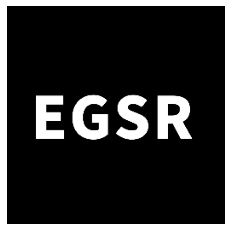

In [6]:
plt.imshow(image_ref, cmap="Greys_r")
plt.axis('off')

## MLP

In [13]:
device = 'cuda'
aggr_func = 'probabilistic'
squared = False
dist_shape = 0.0
dist_shift = 0.0
t_conorm_p = 0.0
losses = ['mse']
dist_eps = 100
gif = True
seed = 0
batch_size = 1
image_size = 64#256
mesh_location = os.path.join('data/pose', model_obj)
num_steps = 300
optimizer_choice = 'adam'
loss_threshold = 0.1
learning_rate = 0.3

learning_rate_meta = 0.03

dist_func = 'mlp'
init_weight = False
weight = 0.50118
if init_weight:
    w1 = torch.nn.Parameter(weight*torch.ones([4*1]).float().to(device))
    w2 = torch.nn.Parameter(weight*torch.ones([4*4]).float().to(device))
    w3 = torch.nn.Parameter(weight*torch.ones([4*4]).float().to(device))
    w4 = torch.nn.Parameter(weight*torch.ones([4*4]).float().to(device))
    w5 = torch.nn.Parameter(weight*torch.ones([1*4]).float().to(device))
else:
    pretrained_weights = list(torch.load("data/shape2D/pretrained_weights.pth").values())
    w1 = torch.nn.Parameter(pretrained_weights[0].to(device))
    w2 = torch.nn.Parameter(pretrained_weights[1].to(device))
    w3 = torch.nn.Parameter(pretrained_weights[2].to(device))
    w4 = torch.nn.Parameter(pretrained_weights[3].to(device))
    w5 = torch.nn.Parameter(pretrained_weights[4].to(device))

####################################################################################################################

lighting = metaras.Lighting()
camera = np.load('data/cameras.npy').astype('float32')[60]
transform = metaras.LookAt(viewing_angle=15)
camera_distances = torch.tensor([camera[0]]) - 1 
elevations = torch.tensor([camera[1]]) 
viewpoints = torch.tensor([camera[2]])
transform.set_eyes_from_angles(camera_distances, elevations, viewpoints)
diff_renderer = metaras.MetaRas(
    image_size= image_size,
    dist_func= dist_func,
    dist_scale=torch.nn.Parameter(torch.tensor([-4.]).to(device)),
    dist_scale_rgb=torch.nn.Parameter(torch.tensor([-4.]).to(device)),
    dist_squared= squared,
    dist_shape= dist_shape,
    dist_shift= dist_shift,
    dist_eps= dist_eps,
    aggr_alpha_func=aggr_func,
    aggr_alpha_t_conorm_p=t_conorm_p,
    aggr_rgb_func= 'hard',
    w1 = w1, 
    w2 = w2, 
    w3 = w3, 
    w4 = w4, 
    w5 = w5, 
)
hard_renderer = metaras.MetaRas(
    image_size= image_size,
    dist_func=0,
    dist_scale=torch.tensor([-4.]).to(device),
    dist_squared=True,
    dist_shape=0.,
    dist_shift=0.,
    dist_eps=10,
    aggr_alpha_func=0,
    aggr_alpha_t_conorm_p=0.,
    aggr_rgb_func='hard',
)

res_directory = f'data/shape2D/original_{diff_renderer.dist_func}'
try:
    os.makedirs(res_directory)
except:
    print("directory exists")
    
model = Model()
mesh = metaras.Mesh(model.vertices, model.faces)

torch.manual_seed(seed)

print('Generating goals...')    
goal = torch.from_numpy(np.array([image_ref]).astype(np.float32))
goal = goal.cpu().numpy()

# uncomment to save the goals
# directory = f'data/shape2D/original_ref'
# try:
#     os.makedirs(directory)
# except:
#     print("directory exists")
# plt.axis("off")
# plt.imshow(goal[0], cmap='Greys_r')
# plt.savefig(f'{directory}/ref.pdf',bbox_inches='tight',pad_inches=0.0)
# plt.clf()

####################################################################################################################

# best_setting = [None, None, 1e10]     #sigma, learning_rate, res

# learning_rate = 0.01

# hard_loss = 1e10

steps_to_threshold = int(1e10)
loop = tqdm(range(num_iterations_meta))
torch.manual_seed(seed+1)

if optimizer_choice == 'adam':
    optim = torch.optim.Adam(model.parameters(), learning_rate, betas=(0.9, 0.99))
    optim_meta = torch.optim.Adam([diff_renderer.w1,
                                   diff_renderer.w2,
                                   diff_renderer.w3,
                                   diff_renderer.w4,
                                   diff_renderer.w5], learning_rate_meta, betas=(0.9, 0.99))
elif optimizer_choice == 'sgd':
    optim = torch.optim.SGD(model.parameters(), learning_rate)
    optim_meta = torch.optim.SGD([diff_renderer.w1,
                                  diff_renderer.w2,
                                  diff_renderer.w3,
                                  diff_renderer.w4,
                                  diff_renderer.w5], learning_rate_meta)
else:
    raise ValueError(optimizer_choice)

for j in loop:
    model.reset()  
    for i in range(num_steps):
        mesh, laplacian_loss, flatten_loss = model(batch_size)
        pred = render(mesh, lighting, transform, diff_renderer)
                    
        # uncomment to save init
        if i == 0 and j == 0:
            directory = f'data/shape2D/original_init'
            try:
                os.makedirs(directory)
            except:
                print("directory exists")
            plt.axis("off")
            plt.imshow(pred.cpu().detach().numpy().transpose(1,2,0)[:,:,:3])
            plt.savefig(f'{directory}/init_{i}.pdf',bbox_inches='tight',pad_inches=0.0)
            plt.clf()
            
        sil_loss = (mse_loss if losses[0] == 'mse' else iou_loss)(pred[:, 3], goal[:, 3])

        with torch.no_grad():
            pred_hard = hard_renderer(mesh)
            hard_sil_loss = (mse_loss if losses[0] == 'mse' else iou_loss)(pred_hard[:, 3], goal[:, 3])
            hard_loss = min(hard_loss, hard_sil_loss)
            if hard_loss < loss_threshold:
                steps_to_threshold = min(i, steps_to_threshold)
        
        all_loss = sil_loss + (0.03 * laplacian_loss)
        optim.zero_grad()
        all_loss.backward()
        optim.step()

    if j < num_iterations_meta - 1:
        mesh, laplacian_loss, flatten_loss = model(batch_size)
        pred = render(mesh, lighting, transform, diff_renderer)

        sil_loss = (mse_loss if losses[0] == 'mse' else iou_loss)(pred[:,3], goal[:,3])

        all_loss = sil_loss + (0.03 * laplacian_loss)
        optim_meta.zero_grad()
        all_loss.backward()
        optim_meta.step()
   
if gif:
    writer = imageio.get_writer('data/shape2D/original_{}_{}.gif'.format(
        model_obj.split('.')[0], diff_renderer.dist_func
    ), mode='I')

history_loss = []
         
model.reset()
for i in tqdm(range(num_steps)):
    mesh, laplacian_loss, flatten_loss = model(batch_size)
    pred = render(mesh, lighting, transform, diff_renderer)
    
    if gif:
        writer.append_data(make_grid(pred, goal, 1, 1))
            
    sil_loss = (mse_loss if losses[0] == 'mse' else iou_loss)(pred[:,3], goal[:,3])

    with torch.no_grad():
        pred_hard = hard_renderer(mesh)[:, 3]
        hard_sil_loss = (mse_loss if losses[0] == 'mse' else iou_loss)(pred_hard[:,3], goal[:,3])
        hard_loss = min(hard_loss, hard_sil_loss)
        if hard_loss < loss_threshold:
            steps_to_threshold = min(i, steps_to_threshold)

    loss = sil_loss + (0.03 * laplacian_loss)
    optim.zero_grad()
    loss.backward()
    optim.step()

    history_loss.append(hard_sil_loss.item())
    
pd_mlp_loss = pd.DataFrame(np.array(history_loss))
pd_mlp_loss.to_csv(f"{res_directory}/loss_silhouette_{model_obj.replace('.jpg','')}.csv",header=None,index=False)

torch.save(diff_renderer._parameters, f"{res_directory}/{model_obj.replace('.jpg','')}.pth")

plt.axis("off")
plt.imshow(pred[i].cpu().detach().numpy().transpose(1,2,0)[:,:,:3])
plt.savefig(f'{res_directory}/{diff_renderer.dist_func}_{i}.pdf',bbox_inches='tight',pad_inches=0.0)
plt.clf()

directory exists
Generating goals...


# Rest

In [46]:
def train_mlp_model(diff_renderer, model, optim, hard_loss):
    
    global steps_to_threshold
    
    optim_meta = torch.optim.Adam([diff_renderer.w1,
                        diff_renderer.w2,
                        diff_renderer.w3,
                        diff_renderer.w4,
                        diff_renderer.w5], args.learning_rate_meta, betas=(0.9, 0.99))
    
    for j in tqdm(range(args.num_iterations_meta)):
        model.reset()
#         optim.param_groups[0]['lr'] -= (0.03 - 0.01)/args.num_iterations_meta
        
        for i in range(args.num_iterations_train):
            mesh, laplacian_loss, flatten_loss = model(len(cameras))
            mesh = lighting(mesh)
            mesh = transform(mesh)
            images_pred = diff_renderer(mesh)[:, 3]
                        
            sil_loss = (mse_loss if args.loss == 'mse' else iou_loss)(images_pred, images_gt)

            with torch.no_grad():
                images_pred_hard = hard_renderer(mesh)[:, 3]
                hard_sil_loss = (mse_loss if args.loss == 'mse' else iou_loss)(images_pred_hard, images_gt)
                hard_loss = min(hard_loss, hard_sil_loss)
                if hard_loss < args.loss_threshold:
                    steps_to_threshold = min(i, steps_to_threshold)
                    
#             writer.append_data(make_grid(images_pred, images_pred_hard, 1, 1))
            
            all_loss = sil_loss + (0.03 * laplacian_loss)# + 0.0003 * flatten_loss)
            optim.zero_grad()
            all_loss.backward()
            optim.step()

        if j < args.num_iterations_meta - 1:
            mesh, laplacian_loss, flatten_loss = model(len(cameras))
            mesh = lighting(mesh)
            mesh = transform(mesh)
            images_pred = diff_renderer(mesh)[:, 3]
            sil_loss = (mse_loss if args.loss == 'mse' else iou_loss)(images_pred, images_gt)

            all_loss = sil_loss + (0.03 * laplacian_loss)# + 0.0003 * flatten_loss)
            optim_meta.zero_grad()
            all_loss.backward()
            optim_meta.step()

In [47]:
def execute_setting(
    diff_renderer,
    learning_rate,
    model,
    mode = "cross",
    sigma = None,
):

    global steps_to_threshold 
    
    writer = imageio.get_writer(os.path.join('gifs', 'shape2D_{}_{}_{}_{}_{}.gif'.format(
        index, args.model_obj.split(".")[0], 
        args.image_size, args.dist_func, 
        args.learning_rate_meta, learning_rate
    )), mode='I')
    
    steps_to_threshold = int(1e10)
    hard_loss = 1e10
        
    if args.optimizer_choice == 'adam':
        optim = torch.optim.Adam(model.parameters(), learning_rate, betas=(0.9, 0.99))
    elif args.optimizer_choice == 'sgd':
        optim = torch.optim.SGD(model.parameters(), learning_rate)
    else:
        raise ValueError(args.optimizer_choice)
        
    if args.dist_func == 'mlp':
        load_mlp_model(diff_renderer) 
        if mode == "train":
            train_mlp_model(diff_renderer, model, optim, hard_loss)   
        else:
            learning_rate_meta = args.learning_rate_meta
            if args.optimizer_choice == 'adam':
                optim = torch.optim.Adam([{"params":model.parameters(),"lr":learning_rate}], betas=(0.9, 0.99))
            elif args.optimizer_choice == 'sgd':
                optim = torch.optim.SGD([{"params":model.parameters(),"lr":learning_rate},
                                        {"params": diff_renderer.w1, "lr": learning_rate_meta},
                                        {"params": diff_renderer.w2, "lr": learning_rate_meta},
                                        {"params": diff_renderer.w3, "lr": learning_rate_meta},
                                        {"params": diff_renderer.w4, "lr": learning_rate_meta},
                                        {"params": diff_renderer.w5, "lr": learning_rate_meta}])
            else:
                raise ValueError(args.optimizer_choice)
    else:       
        print("set dist scale", sigma)
        diff_renderer.dist_scale = sigma

    model.reset()
    for i in range(args.num_iterations_train):
        mesh, laplacian_loss, flatten_loss = model(len(cameras))
        mesh = lighting(mesh)
        mesh = transform(mesh)
        images_pred = diff_renderer(mesh)[:, 3]

        sil_loss = (mse_loss if args.loss == 'mse' else iou_loss)(images_pred, images_gt)
        
        writer.append_data(make_grid(images_pred, images_gt, 1, 1))

        with torch.no_grad():
            images_pred = hard_renderer(mesh)[:, 3]
            hard_sil_loss = (mse_loss if args.loss == 'mse' else iou_loss)(images_pred, images_gt)
            hard_loss = min(hard_loss, hard_sil_loss)
            if hard_loss < args.loss_threshold:
                steps_to_threshold = min(i, steps_to_threshold)

        loss = sil_loss + (0.03 * laplacian_loss)# + 0.0003 * flatten_loss)
        optim.zero_grad()
        loss.backward()
        optim.step()
#         history_loss.append(loss.item())
        history_loss.append(hard_sil_loss.cpu())
        
    if args.dist_func == 'mlp':
        torch.save(diff_renderer.state_dict(),'data/weights/shape2D_{index}_{image_size}_{l}_{best:.3f}.pth'.format(
            index = index, image_size=args.image_size, l = args.learning_rate_meta,best=np.min(history_loss)))
        print('data/weights/shape2D_{index}_{image_size}_{l}_{best:.3f}.pth'.format(
            index = index, image_size=args.image_size, l = args.learning_rate_meta,best=np.min(history_loss)))
    
    plt.figure()
    with torch.no_grad():
        plt.plot(history_loss)
        plt.show()
    
    np.savetxt(f'loss_{args.model_obj}_{index}_{args.dist_func}_{args.image_size}_{learning_rate}.txt',history_loss)
    
    if args.criterion == 'loss':
        return hard_loss.item()
    elif args.criterion == 'steps_to_threshold':
        return steps_to_threshold
    else:
        raise ValueError(args.criterion)

In [48]:
def train(diff_renderer, model, views):
    global history_loss
    global all_hist_loss
    
    best_setting = [None, None, 1e10]     #sigma, learning_rate, res

    assert args.optimizer_choice == 'adam', args.optimizer_choice
    
    if args.dist_func == 'mlp':
        learning_rate = 0.01
#         loop = [0.01]
#         loop = np.logspace(-1.25, -3, 8)
#         loop = np.append(loop, [0.001, 0.005, 0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7])
    else:
        loop = np.logspace(-1.25, -1.75, 3)

    file = open("data/2D_experiments.txt", "a")
    file.write(f'============= Experiment {index} =============\n')
    file.write(f'^^^^^^^^^^^^^ {args.model_obj.split(".")[0]} ^^^^^^^^^^^^^\n')
    file.write(f'Func:\t\t\t\t{args.dist_func}\n' +
                f'Image Size:\t\t\t{args.image_size}\n')
    file.close()
    
    file = open("data/2D_experiments.txt", "a")
    history_loss = []
    if args.dist_func == 'mlp':
        res = execute_setting(diff_renderer, learning_rate, model, sigma = None)
        print("loss:", history_loss[-1])

        file = open("data/2D_experiments.txt", "a")
        file.write(
            'learning rate:\t\t{}\n'.format(learning_rate) +
            args.criterion + ':\t\t\t\t{}\n'.format(res)
        )

        if res < best_setting[2]:
            best_setting[1:] = [learning_rate, res]
            
        file.write(f'Meta Iterations:\t{args.num_iterations_meta}\n' +
            f'Meta LR:\t\t\t{args.learning_rate_meta}\n')
        file.close()

    else:
        
        if args.dist_func == "logistic":
            best_setting = [1e-06, 0.01778279410038923, 0.0033484837040305138]
        elif args.dist_func == "gaussian":
            best_setting = [9.999999999999999e-06, 0.01778279410038923, 0.0036145849153399467]
        elif args.dist_func == "exponential":
            best_setting = [9.999999999999999e-06, 0.01778279410038923, 0.003815282601863146]
        elif args.dist_func == "gamma":
            best_setting = [1e-06, 0.01778279410038923, 0.004546746611595154]
            
        res = execute_setting(diff_renderer, best_setting[1], model, sigma=best_setting[0])

        file.write(
            'learning rate:\t\t{}\n'.format(best_setting[1]) +
            'sigma:\t\t\t\t{}\n'.format(best_setting[0]) +
            args.criterion + ':\t\t\t\t{}\n'.format(best_setting[2])
        )

        print(history_loss[-1])
    file.close()
    
    all_hist_loss.append(history_loss)
    
#     for learning_rate in (loop):
#         print("lr:", learning_rate)
#         history_loss = []
#         if args.dist_func == 'mlp':
#             res = execute_setting(diff_renderer, learning_rate, model, mode="train", sigma = None)
#             print("loss:", history_loss[-1])
            
#             file = open("data/2D_experiments.txt", "a")
#             file.write(
#                 'learning rate:\t\t{}\n'.format(learning_rate) +
#                 args.criterion + ':\t\t\t\t{}\n'.format(res)
#             )
#             file.close()
            
#             if res < best_setting[2]:
#                 best_setting[1:] = [learning_rate, res]
                
#         else:
#             print("sigma loop")
#             for sigma in np.logspace(-1, -7, 7):
#                 history_loss = []
#                 res = execute_setting(diff_renderer, learning_rate, model, sigma=sigma)
#                 if res < best_setting[2]:
#                     best_setting = [sigma, learning_rate, res]
#                 print(history_loss[-1])
                    
#     file = open("data/2D_experiments.txt", "a")
    
#     history_loss = []
#     if args.dist_func != 'mlp':
#         print("best setting:", best_setting)
#         execute_setting(diff_renderer, best_setting[1], model, sigma = best_setting[0])
#         file.write(
#             'learning rate:\t\t{}\n'.format(best_setting[1]) +
#             'sigma:\t\t\t\t{}\n'.format(best_setting[0]) +
#             args.criterion + ':\t\t\t\t{}\n'.format(best_setting[2])
#         )
#     else:
#         file.write(f'Meta Iterations:\t{args.num_iterations_meta}\n' +
#                 f'Meta LR:\t\t\t{args.learning_rate_meta}\n')
        
#     file.close()
    
#     execute_setting_for_gif(diff_renderer, best_setting[1], model, best_setting[0])

In [49]:
def experiment(diff_renderer):
#     for views in ['24@-60', '24@-30', '24@0', '24@30', '24@60']:

    global cameras
    global images
    global images_gt
    
    for views in ['24@0']:

        if views == 'all':
            pass
        elif views == '4@30':
            images = all_images[3*24:4*24]
            cameras = all_cameras[3*24:4*24]
            images = images[::6]
            cameras = cameras[::6]
        elif views == '8@30':
            images = all_images[3*24:4*24]
            cameras = all_cameras[3*24:4*24]
            images = images[::3]
            cameras = cameras[::3]
        elif views == '24@-60':
            j = 0
            images = all_images[j*24:(j+1)*24]
            cameras = all_cameras[j*24:(j+1)*24]
        elif views == '24@-30':
            j = 1
            images = all_images[j*24:(j+1)*24]
            cameras = all_cameras[j*24:(j+1)*24]
        elif views == '24@0':
            j = 2
            images = all_images[j*24:(j+1)*24][0:1]
            cameras = all_cameras[j*24:(j+1)*24][0:1]
        elif views == '24@30':
            j = 3
            images = all_images[j*24:(j+1)*24]
            cameras = all_cameras[j*24:(j+1)*24]
        elif views == '24@60':
            j = 4
            images = all_images[j*24:(j+1)*24]
            cameras = all_cameras[j*24:(j+1)*24]
        else:
            raise ValueError(args.views)

        camera_distances = torch.from_numpy(cameras[:, 0]) - 1
        elevations = torch.from_numpy(cameras[:, 1])
        viewpoints = torch.from_numpy(cameras[:, 2])
        transform.set_eyes_from_angles(camera_distances, elevations, viewpoints)

        images_gt = torch.from_numpy(images).to(device)    
        model = Model().to(device)
        
        train(diff_renderer, model, views)
        
        return model, diff_renderer

In [50]:
def get_renderer():
    if args.dist_func == 'mlp':
        diff_renderer = metaras.MetaRas(
            image_size= args.image_size,
            dist_func= "mlp",
            dist_scale= torch.tensor([args.dist_scale]).to(device),
            dist_scale_rgb= torch.tensor([args.dist_scale]).to(device),
            dist_squared= args.squared,
            dist_shape= args.dist_shape,
            dist_shift= args.dist_shift,
            dist_eps= args.dist_eps,
            aggr_alpha_func= args.aggr_func,
            aggr_alpha_t_conorm_p= args.t_conorm_p,
            aggr_rgb_func= 'hard',
            w1 = torch.nn.Parameter(torch.rand([4*1]).float().to(device)),
            w2 = torch.nn.Parameter(torch.rand([4*4]).float().to(device)),
            w3 = torch.nn.Parameter(torch.rand([4*4]).float().to(device)),
            w4 = torch.nn.Parameter(torch.rand([4*4]).float().to(device)),
            w5 = torch.nn.Parameter(torch.rand([1*4]).float().to(device))
        )
        
    else:
        diff_renderer = gendr.GenDR(
            image_size= args.image_size,
            dist_func=args.dist_func,
            dist_scale=None,
            dist_squared=True,
            dist_shape=args.dist_shape,
            dist_shift=args.dist_shift,
            dist_eps=args.dist_eps,
            aggr_alpha_func=args.aggr_func,
            aggr_alpha_t_conorm_p=args.t_conorm_p,
            aggr_rgb_func='hard',
        )
        
    hard_renderer = metaras.MetaRas(
        image_size= args.image_size,
        dist_func=0,
        dist_scale=torch.tensor([-4.]).to(device),
        dist_squared=True,
        dist_shape=0.,
        dist_shift=0.,
        dist_eps=1,
        aggr_alpha_func=0,
        aggr_alpha_t_conorm_p=0.,
        aggr_rgb_func='hard',
    )
    
    return diff_renderer, hard_renderer

In [51]:
device = 'cuda'

lighting = metaras.Lighting()
all_cameras = np.load(os.path.join(data_dir, 'cameras.npy')).astype('float32')
transform = metaras.LookAt(viewing_angle=15)

print('all_cameras.shape', all_cameras.shape)

all_cameras.shape (120, 3)


index 0
image size: 256, meta iters: 50, meta lr: 0.1, sq: False, func: logistic
{'dist_func': 'logistic', 'aggr_func': 'probabilistic', 'dist_scale': -1.0, 'dist_shape': 2, 'dist_shift': 0.0, 't_conorm_p': 0.0, 'model_obj': 'EGSR2024', 'optimizer_choice': 'adam', 'num_iterations': 100, 'num_vertices': 642, 'image_size': 256, 'dist_eps': 100, 'loss': 'mse', 'loss_threshold': 0.1, 'criterion': 'loss', 'learning_rate_meta': 0.1, 'num_iterations_meta': 50, 'num_iterations_train': 200, 'weight': 0.50118, 'squared': False, 'gif': False, 'init_weight': False}



  0%|          | 0/20 [00:00<?, ?it/s]

Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


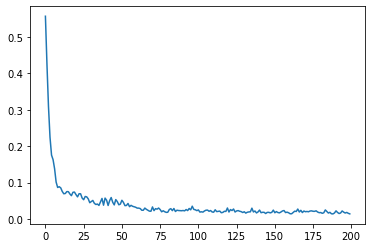


  5%|▌         | 1/20 [04:58<1:34:26, 298.22s/it]

tensor(0.0141)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


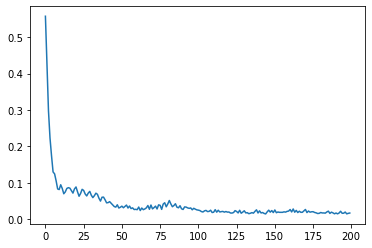


 10%|█         | 2/20 [09:55<1:29:15, 297.53s/it]

tensor(0.0170)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


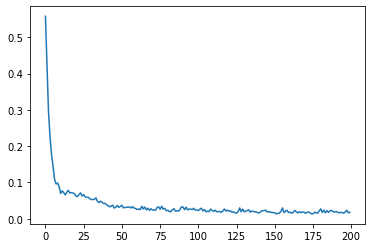


 15%|█▌        | 3/20 [15:14<1:27:05, 307.36s/it]

tensor(0.0178)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


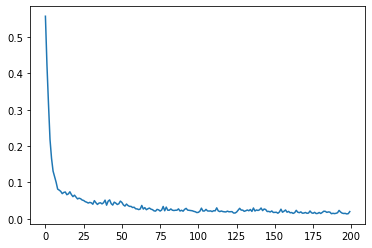


 20%|██        | 4/20 [20:23<1:22:11, 308.19s/it]

tensor(0.0198)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


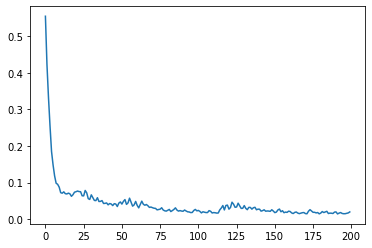


 25%|██▌       | 5/20 [25:32<1:17:07, 308.48s/it]

tensor(0.0195)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


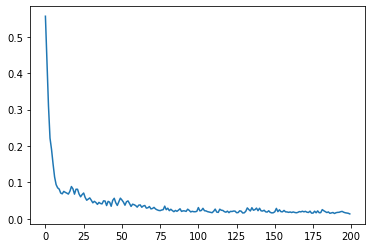


 30%|███       | 6/20 [30:34<1:11:25, 306.10s/it]

tensor(0.0133)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


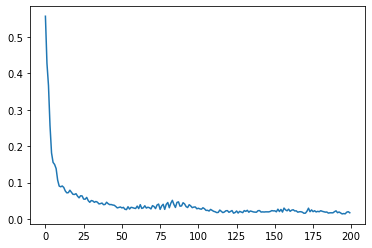


 35%|███▌      | 7/20 [35:24<1:05:10, 300.82s/it]

tensor(0.0173)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


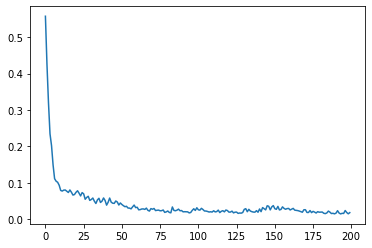


 40%|████      | 8/20 [40:05<58:54, 294.52s/it]  

tensor(0.0181)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


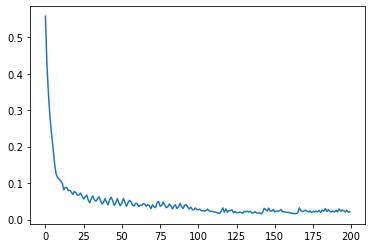


 45%|████▌     | 9/20 [44:50<53:27, 291.55s/it]

tensor(0.0215)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


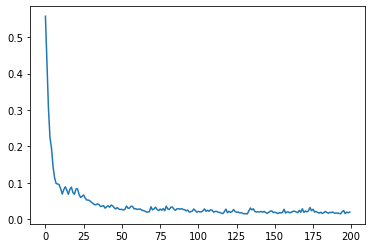


 50%|█████     | 10/20 [49:53<49:11, 295.17s/it]

tensor(0.0196)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


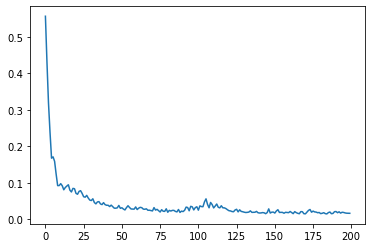


 55%|█████▌    | 11/20 [54:28<43:20, 288.93s/it]

tensor(0.0165)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


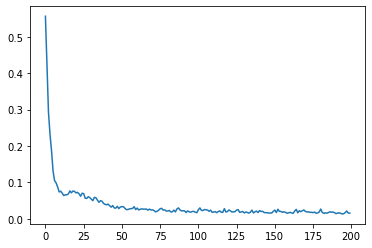


 60%|██████    | 12/20 [58:31<36:39, 274.91s/it]

tensor(0.0158)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


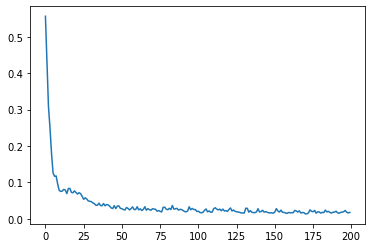


 65%|██████▌   | 13/20 [1:02:35<31:00, 265.74s/it]

tensor(0.0178)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


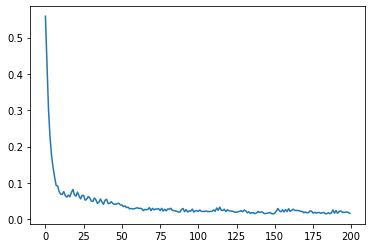


 70%|███████   | 14/20 [1:06:32<25:41, 256.92s/it]

tensor(0.0160)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


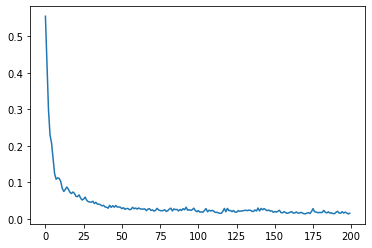


 75%|███████▌  | 15/20 [1:10:33<21:00, 252.03s/it]

tensor(0.0159)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


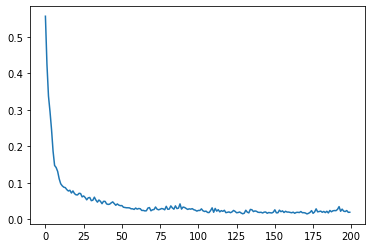


 80%|████████  | 16/20 [1:14:37<16:38, 249.67s/it]

tensor(0.0195)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


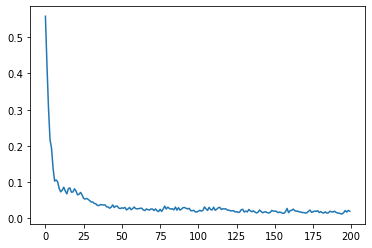


 85%|████████▌ | 17/20 [1:18:37<12:20, 246.84s/it]

tensor(0.0199)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


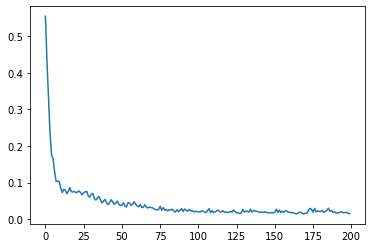


 90%|█████████ | 18/20 [1:22:35<08:08, 244.27s/it]

tensor(0.0150)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


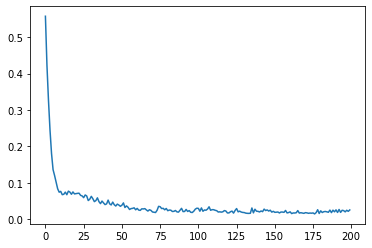


 95%|█████████▌| 19/20 [1:26:39<04:04, 244.26s/it]

tensor(0.0258)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


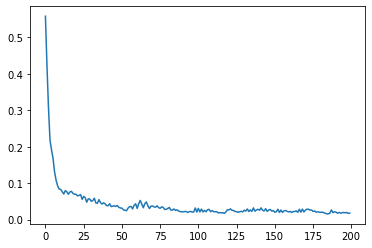

100%|██████████| 20/20 [1:30:44<00:00, 272.23s/it]

tensor(0.0177)


index 20
image size: 256, meta iters: 50, meta lr: 0.1, sq: False, func: gaussian
{'dist_func': 'logistic', 'aggr_func': 'probabilistic', 'dist_scale': -1.0, 'dist_shape': 2, 'dist_shift': 0.0, 't_conorm_p': 0.0, 'model_obj': 'EGSR2024', 'optimizer_choice': 'adam', 'num_iterations': 100, 'num_vertices': 642, 'image_size': 256, 'dist_eps': 100, 'loss': 'mse', 'loss_threshold': 0.1, 'criterion': 'loss', 'learning_rate_meta': 0.1, 'num_iterations_meta': 50, 'num_iterations_train': 200, 'weight': 0.50118, 'squared': False, 'gif': False, 'init_weight': False}



  0%|          | 0/20 [00:00<?, ?it/s]

Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


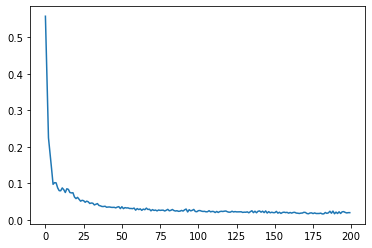


  5%|▌         | 1/20 [04:19<1:22:10, 259.50s/it]

tensor(0.0199)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


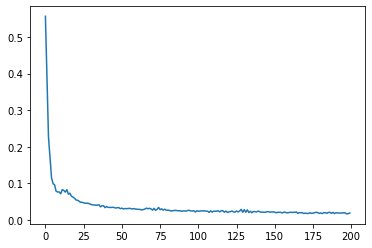


 10%|█         | 2/20 [08:50<1:19:54, 266.35s/it]

tensor(0.0184)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


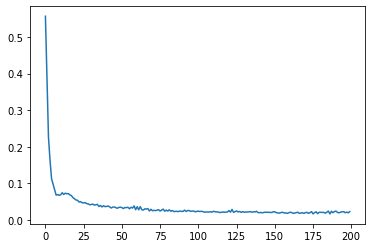


 15%|█▌        | 3/20 [12:55<1:12:39, 256.42s/it]

tensor(0.0224)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


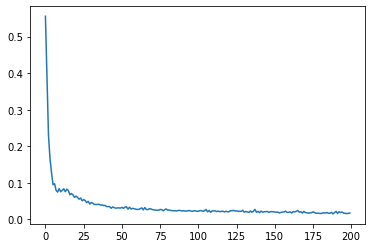


 20%|██        | 4/20 [18:00<1:13:30, 275.64s/it]

tensor(0.0175)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


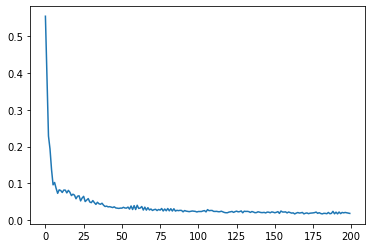


 25%|██▌       | 5/20 [22:31<1:08:29, 273.96s/it]

tensor(0.0185)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


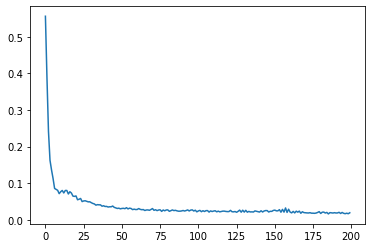


 30%|███       | 6/20 [27:16<1:04:48, 277.72s/it]

tensor(0.0191)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


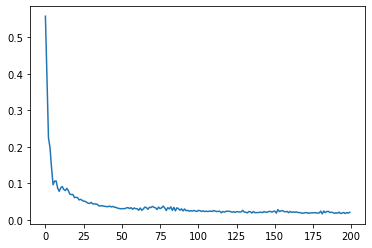


 35%|███▌      | 7/20 [31:58<1:00:27, 279.05s/it]

tensor(0.0205)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


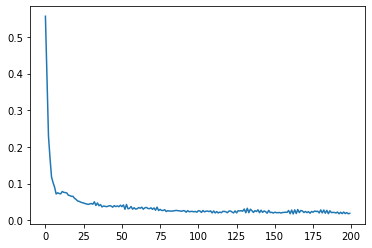


 40%|████      | 8/20 [36:09<54:03, 270.28s/it]  

tensor(0.0188)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


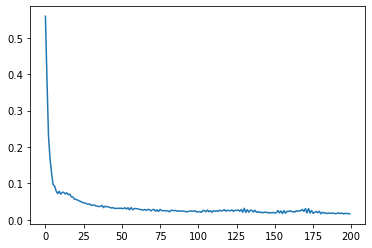


 45%|████▌     | 9/20 [40:24<48:39, 265.39s/it]

tensor(0.0167)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


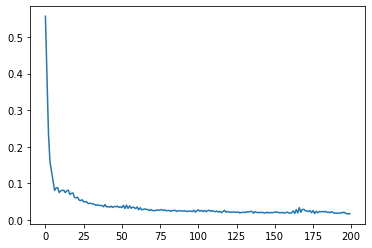


 50%|█████     | 10/20 [44:26<43:00, 258.09s/it]

tensor(0.0173)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


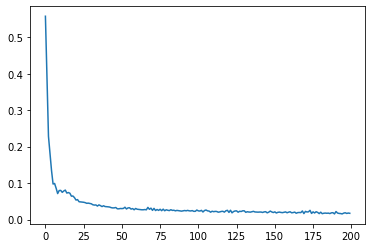


 55%|█████▌    | 11/20 [48:30<38:06, 254.03s/it]

tensor(0.0173)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


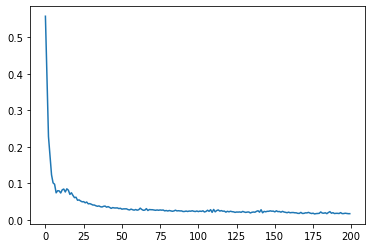


 60%|██████    | 12/20 [52:34<33:26, 250.76s/it]

tensor(0.0170)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


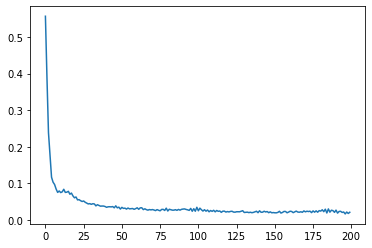


 65%|██████▌   | 13/20 [56:36<28:58, 248.30s/it]

tensor(0.0208)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


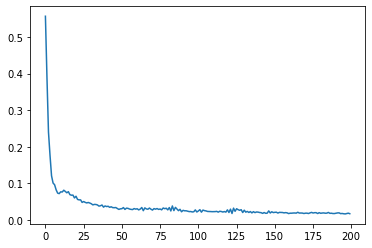


 70%|███████   | 14/20 [1:00:40<24:40, 246.81s/it]

tensor(0.0175)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


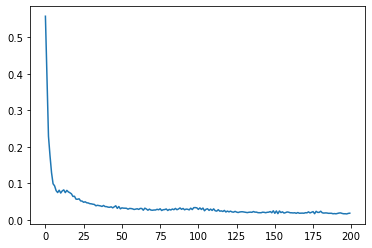


 75%|███████▌  | 15/20 [1:04:52<20:42, 248.53s/it]

tensor(0.0187)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


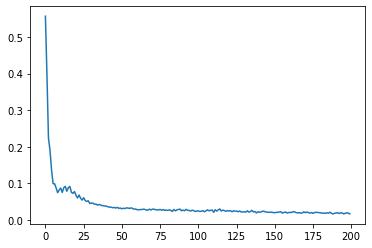


 80%|████████  | 16/20 [1:08:54<16:25, 246.37s/it]

tensor(0.0170)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


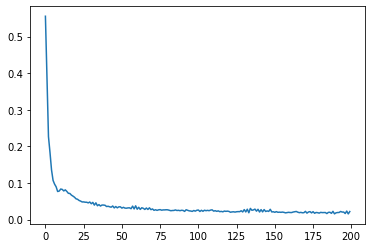


 85%|████████▌ | 17/20 [1:12:57<12:16, 245.52s/it]

tensor(0.0220)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


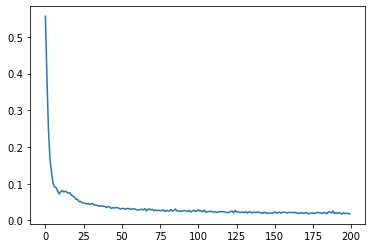


 90%|█████████ | 18/20 [1:17:02<08:10, 245.38s/it]

tensor(0.0178)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


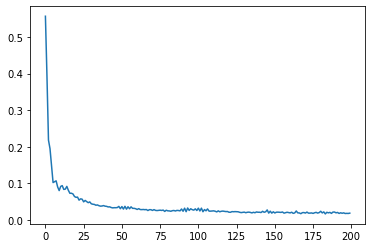


 95%|█████████▌| 19/20 [1:21:18<04:08, 248.62s/it]

tensor(0.0186)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


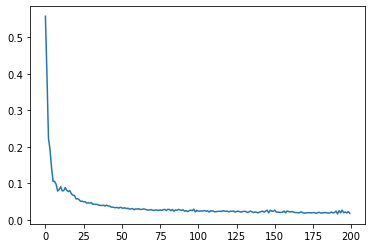

100%|██████████| 20/20 [1:25:30<00:00, 256.50s/it]

tensor(0.0178)


index 40
image size: 256, meta iters: 50, meta lr: 0.1, sq: False, func: exponential
{'dist_func': 'gaussian', 'aggr_func': 'probabilistic', 'dist_scale': -1.0, 'dist_shape': 2, 'dist_shift': 0.0, 't_conorm_p': 0.0, 'model_obj': 'EGSR2024', 'optimizer_choice': 'adam', 'num_iterations': 100, 'num_vertices': 642, 'image_size': 256, 'dist_eps': 100, 'loss': 'mse', 'loss_threshold': 0.1, 'criterion': 'loss', 'learning_rate_meta': 0.1, 'num_iterations_meta': 50, 'num_iterations_train': 200, 'weight': 0.50118, 'squared': False, 'gif': False, 'init_weight': False}



  0%|          | 0/20 [00:00<?, ?it/s]

Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


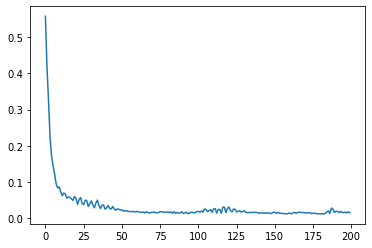


  5%|▌         | 1/20 [04:03<1:17:14, 243.90s/it]

tensor(0.0152)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


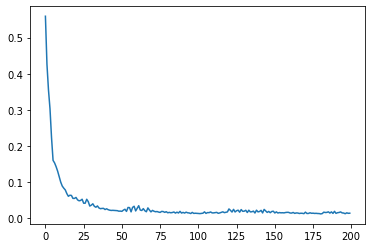


 10%|█         | 2/20 [08:19<1:15:09, 250.52s/it]

tensor(0.0140)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


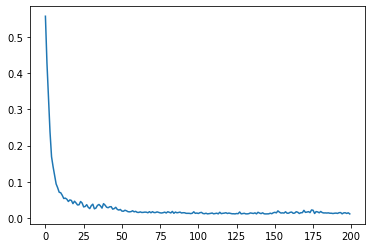


 15%|█▌        | 3/20 [12:27<1:10:42, 249.57s/it]

tensor(0.0119)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


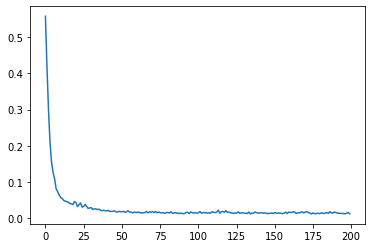


 20%|██        | 4/20 [16:28<1:05:37, 246.07s/it]

tensor(0.0117)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


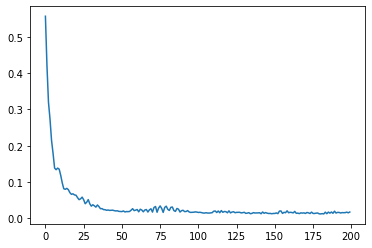


 25%|██▌       | 5/20 [20:31<1:01:14, 244.98s/it]

tensor(0.0172)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


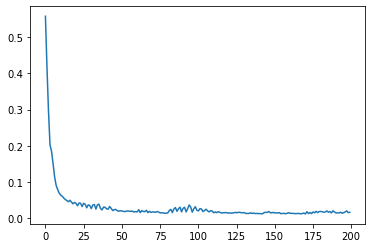


 30%|███       | 6/20 [24:37<57:15, 245.40s/it]  

tensor(0.0158)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


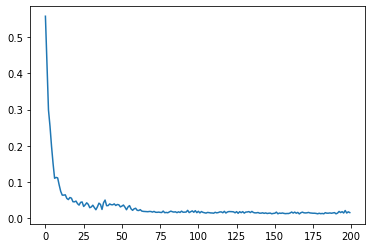


 35%|███▌      | 7/20 [28:37<52:46, 243.58s/it]

tensor(0.0148)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


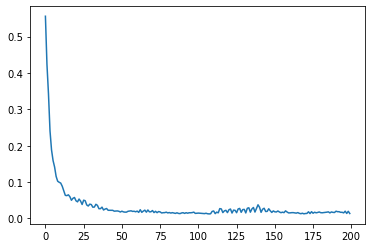


 40%|████      | 8/20 [32:41<48:43, 243.65s/it]

tensor(0.0136)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


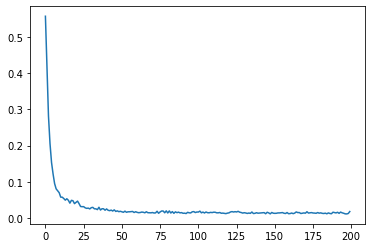


 45%|████▌     | 9/20 [36:44<44:39, 243.57s/it]

tensor(0.0173)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


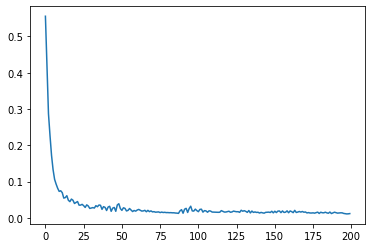


 50%|█████     | 10/20 [40:49<40:39, 243.99s/it]

tensor(0.0120)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


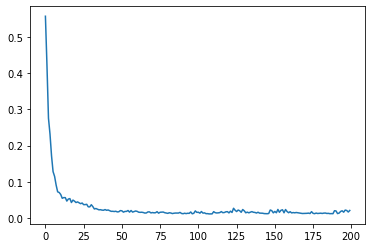


 55%|█████▌    | 11/20 [44:47<36:18, 242.09s/it]

tensor(0.0212)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


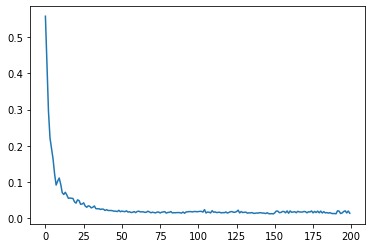


 60%|██████    | 12/20 [48:50<32:20, 242.58s/it]

tensor(0.0136)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


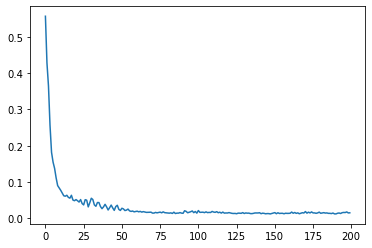


 65%|██████▌   | 13/20 [52:47<28:05, 240.76s/it]

tensor(0.0151)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


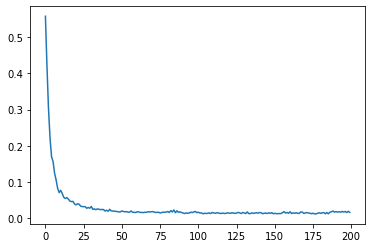


 70%|███████   | 14/20 [56:46<24:00, 240.13s/it]

tensor(0.0160)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


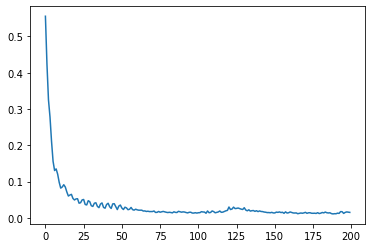


 75%|███████▌  | 15/20 [1:00:42<19:55, 239.04s/it]

tensor(0.0153)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


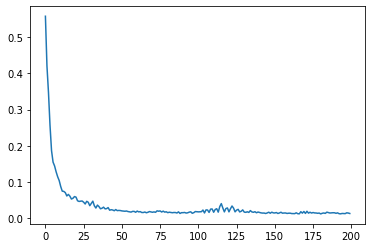


 80%|████████  | 16/20 [1:04:55<16:13, 243.29s/it]

tensor(0.0129)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


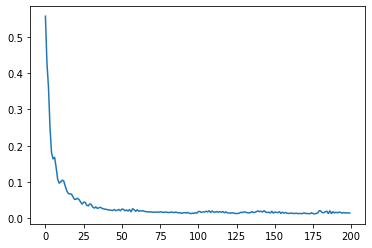


 85%|████████▌ | 17/20 [1:08:56<12:07, 242.60s/it]

tensor(0.0141)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


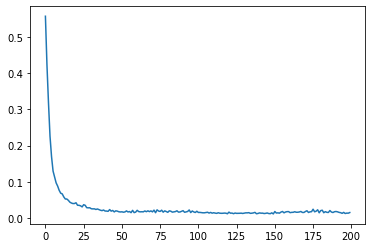


 90%|█████████ | 18/20 [1:12:56<08:03, 241.64s/it]

tensor(0.0148)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


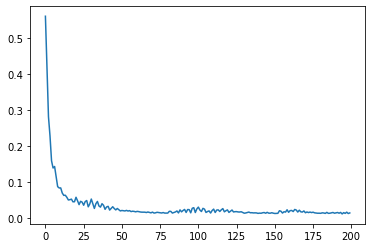


 95%|█████████▌| 19/20 [1:17:04<04:03, 243.71s/it]

tensor(0.0148)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 9.999999999999999e-06


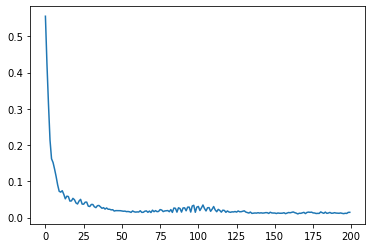

100%|██████████| 20/20 [1:21:05<00:00, 243.29s/it]

tensor(0.0146)


index 60
image size: 256, meta iters: 50, meta lr: 0.1, sq: False, func: gamma
{'dist_func': 'exponential', 'aggr_func': 'probabilistic', 'dist_scale': -1.0, 'dist_shape': 2, 'dist_shift': 0.0, 't_conorm_p': 0.0, 'model_obj': 'EGSR2024', 'optimizer_choice': 'adam', 'num_iterations': 100, 'num_vertices': 642, 'image_size': 256, 'dist_eps': 100, 'loss': 'mse', 'loss_threshold': 0.1, 'criterion': 'loss', 'learning_rate_meta': 0.1, 'num_iterations_meta': 50, 'num_iterations_train': 200, 'weight': 0.50118, 'squared': False, 'gif': False, 'init_weight': False}



  0%|          | 0/20 [00:00<?, ?it/s]

Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


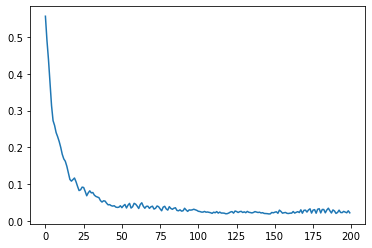


  5%|▌         | 1/20 [04:05<1:17:42, 245.37s/it]

tensor(0.0225)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


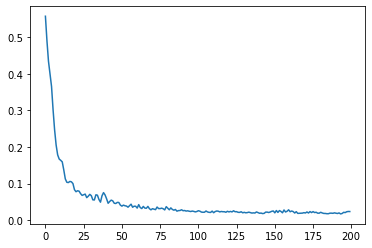


 10%|█         | 2/20 [08:09<1:13:26, 244.78s/it]

tensor(0.0234)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


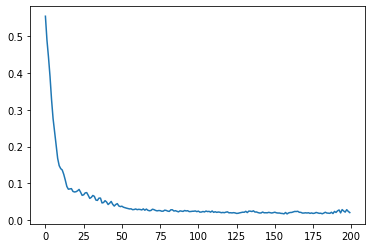


 15%|█▌        | 3/20 [12:20<1:10:09, 247.59s/it]

tensor(0.0204)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


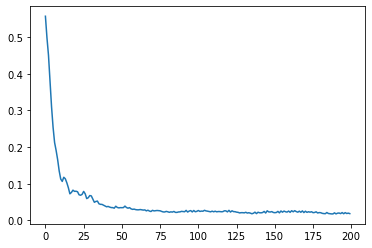


 20%|██        | 4/20 [16:22<1:05:26, 245.43s/it]

tensor(0.0182)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


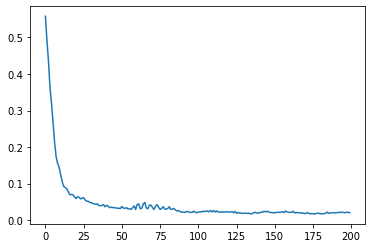


 25%|██▌       | 5/20 [20:24<1:01:03, 244.21s/it]

tensor(0.0204)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


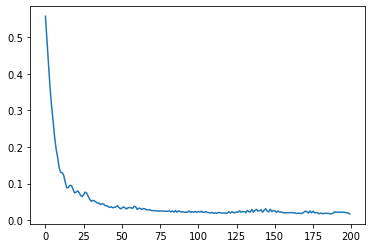


 30%|███       | 6/20 [24:22<56:27, 241.99s/it]  

tensor(0.0171)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


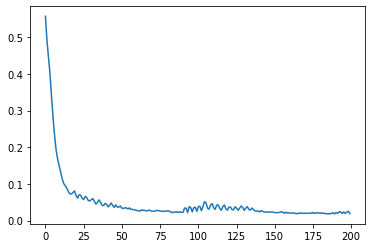


 35%|███▌      | 7/20 [28:27<52:38, 242.94s/it]

tensor(0.0193)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


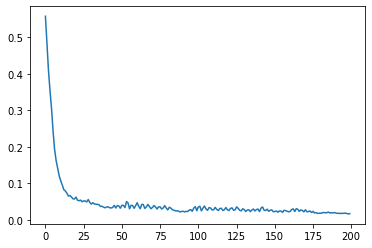


 40%|████      | 8/20 [32:29<48:31, 242.61s/it]

tensor(0.0172)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


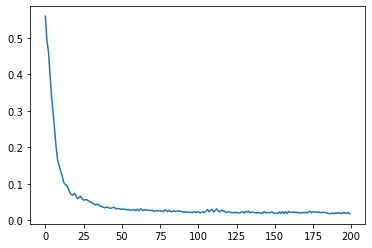


 45%|████▌     | 9/20 [36:29<44:19, 241.79s/it]

tensor(0.0172)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


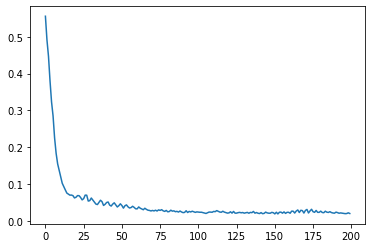


 50%|█████     | 10/20 [40:27<40:07, 240.73s/it]

tensor(0.0195)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


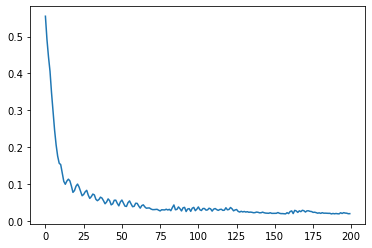


 55%|█████▌    | 11/20 [44:31<36:15, 241.76s/it]

tensor(0.0191)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


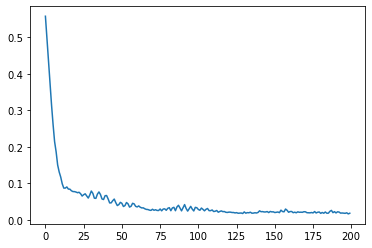


 60%|██████    | 12/20 [48:31<32:09, 241.20s/it]

tensor(0.0183)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


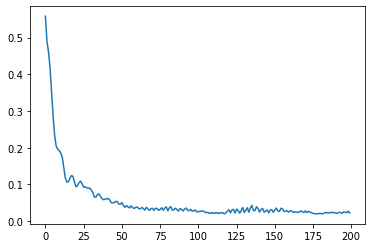


 65%|██████▌   | 13/20 [52:31<28:05, 240.80s/it]

tensor(0.0226)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


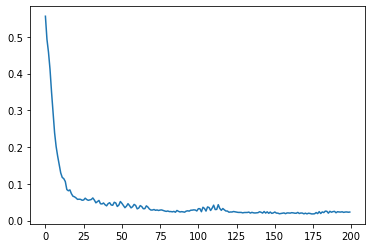


 70%|███████   | 14/20 [56:31<24:02, 240.41s/it]

tensor(0.0234)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


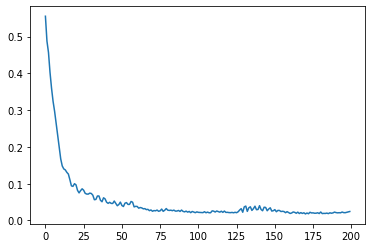


 75%|███████▌  | 15/20 [1:00:32<20:03, 240.75s/it]

tensor(0.0244)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


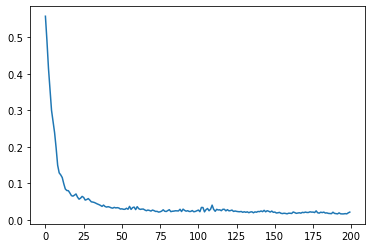


 80%|████████  | 16/20 [1:04:59<16:34, 248.66s/it]

tensor(0.0211)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


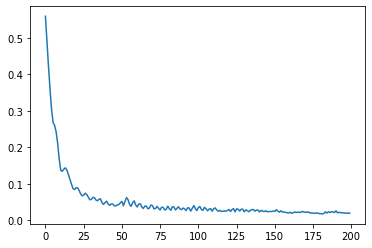


 85%|████████▌ | 17/20 [1:09:52<13:06, 262.07s/it]

tensor(0.0196)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


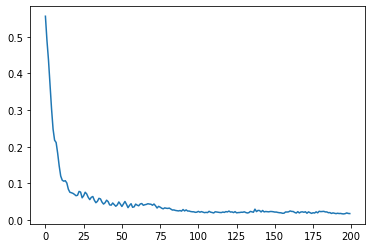


 90%|█████████ | 18/20 [1:15:25<09:26, 283.26s/it]

tensor(0.0179)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


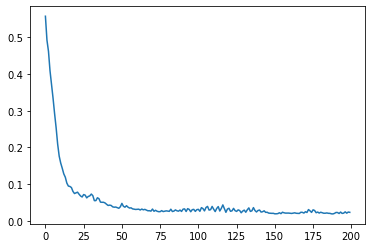


 95%|█████████▌| 19/20 [1:20:22<04:47, 287.52s/it]

tensor(0.0228)
Generating goals...
done.
all_images.shape (120, 256, 256)
set dist scale 1e-06


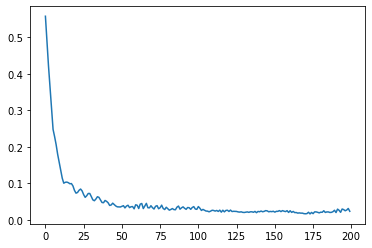

100%|██████████| 20/20 [1:25:11<00:00, 255.60s/it]


tensor(0.0233)
index 80
image size: 256, meta iters: 50, meta lr: 0.1, sq: False, func: mlp
{'dist_func': 'gamma', 'aggr_func': 'probabilistic', 'dist_scale': -1.0, 'dist_shape': 2, 'dist_shift': 0.0, 't_conorm_p': 0.0, 'model_obj': 'EGSR2024', 'optimizer_choice': 'adam', 'num_iterations': 100, 'num_vertices': 642, 'image_size': 256, 'dist_eps': 100, 'loss': 'mse', 'loss_threshold': 0.1, 'criterion': 'loss', 'learning_rate_meta': 0.1, 'num_iterations_meta': 50, 'num_iterations_train': 200, 'weight': 0.50118, 'squared': False, 'gif': False, 'init_weight': False}



  0%|          | 0/20 [00:00<?, ?it/s]

Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_80_256_0.1_0.008.pth


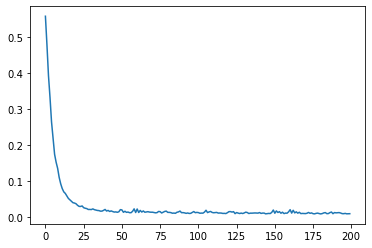


  5%|▌         | 1/20 [05:33<1:45:32, 333.30s/it]

loss: tensor(0.0089)
Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_81_256_0.1_0.008.pth


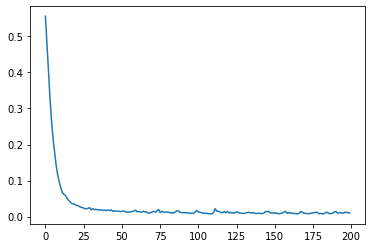


 10%|█         | 2/20 [10:44<1:36:09, 320.51s/it]

loss: tensor(0.0099)
Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_82_256_0.1_0.008.pth


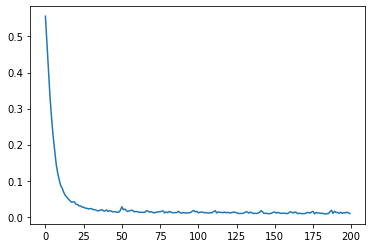


 15%|█▌        | 3/20 [15:59<1:30:01, 317.74s/it]

loss: tensor(0.0087)
Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_83_256_0.1_0.007.pth


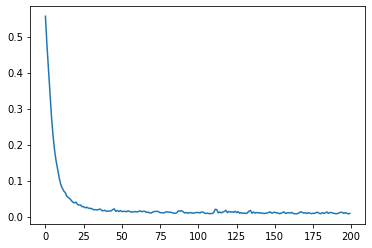


 20%|██        | 4/20 [21:13<1:24:22, 316.40s/it]

loss: tensor(0.0089)
Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_84_256_0.1_0.008.pth


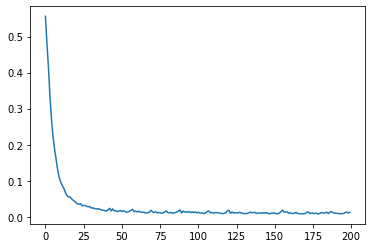


 25%|██▌       | 5/20 [26:44<1:20:25, 321.67s/it]

loss: tensor(0.0123)
Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_85_256_0.1_0.008.pth


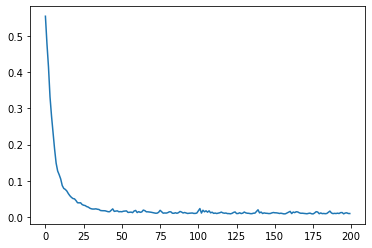


 30%|███       | 6/20 [32:30<1:16:58, 329.88s/it]

loss: tensor(0.0094)
Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_86_256_0.1_0.008.pth


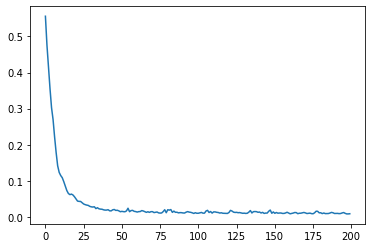


 35%|███▌      | 7/20 [38:05<1:11:48, 331.45s/it]

loss: tensor(0.0086)
Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_87_256_0.1_0.007.pth


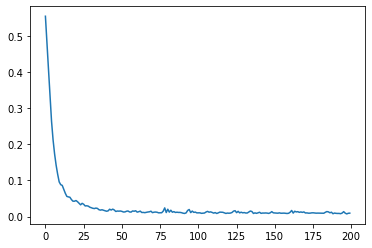


 40%|████      | 8/20 [43:20<1:05:15, 326.28s/it]

loss: tensor(0.0094)
Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_88_256_0.1_0.008.pth


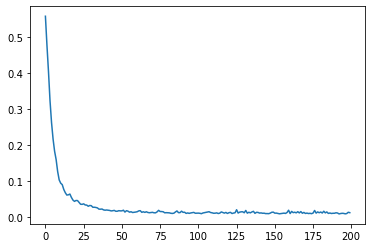


 45%|████▌     | 9/20 [48:52<1:00:10, 328.24s/it]

loss: tensor(0.0116)
Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_89_256_0.1_0.008.pth


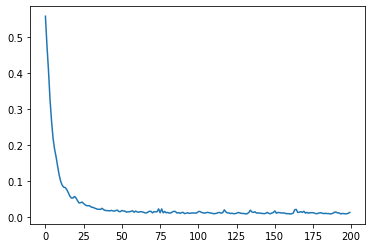


 50%|█████     | 10/20 [54:13<54:17, 325.76s/it] 

loss: tensor(0.0125)
Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_90_256_0.1_0.008.pth


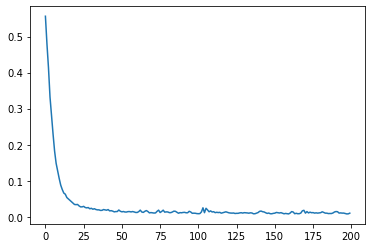


 55%|█████▌    | 11/20 [59:00<47:06, 314.01s/it]

loss: tensor(0.0099)
Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_91_256_0.1_0.008.pth


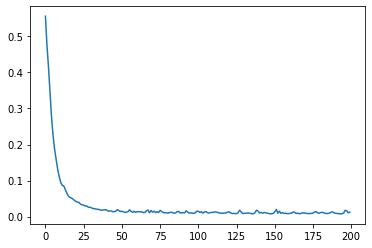


 60%|██████    | 12/20 [1:03:55<41:06, 308.26s/it]

loss: tensor(0.0126)
Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_92_256_0.1_0.008.pth


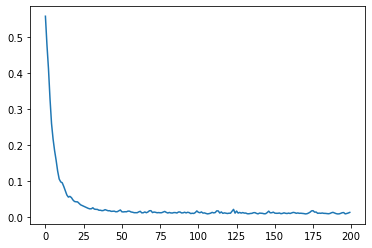


 65%|██████▌   | 13/20 [1:08:58<35:45, 306.52s/it]

loss: tensor(0.0120)
Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_93_256_0.1_0.008.pth


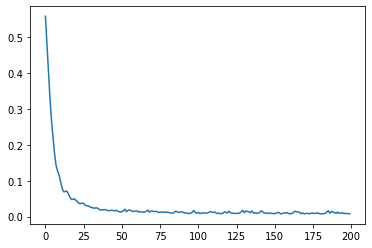


 70%|███████   | 14/20 [1:14:00<30:31, 305.18s/it]

loss: tensor(0.0081)
Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_94_256_0.1_0.008.pth


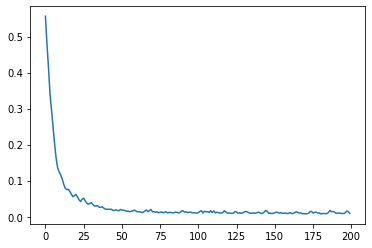


 75%|███████▌  | 15/20 [1:18:59<25:17, 303.48s/it]

loss: tensor(0.0095)
Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_95_256_0.1_0.008.pth


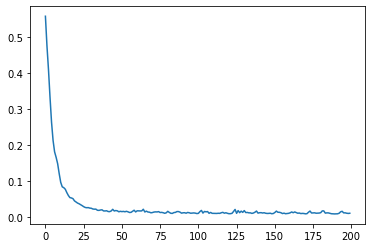


 80%|████████  | 16/20 [1:24:08<20:20, 305.08s/it]

loss: tensor(0.0096)
Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_96_256_0.1_0.008.pth


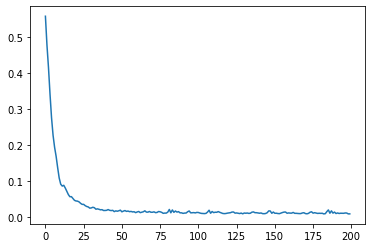


 85%|████████▌ | 17/20 [1:29:09<15:11, 303.98s/it]

loss: tensor(0.0082)
Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_97_256_0.1_0.008.pth


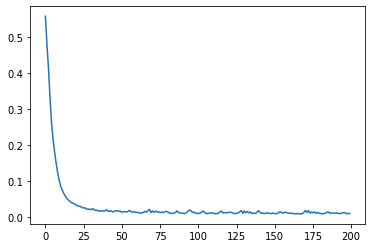


 90%|█████████ | 18/20 [1:34:27<10:16, 308.11s/it]

loss: tensor(0.0090)
Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_98_256_0.1_0.007.pth


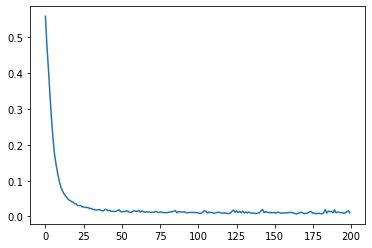


 95%|█████████▌| 19/20 [1:39:39<05:09, 309.33s/it]

loss: tensor(0.0104)
Generating goals...
done.
all_images.shape (120, 256, 256)
data/weights/shape2D_99_256_0.1_0.008.pth


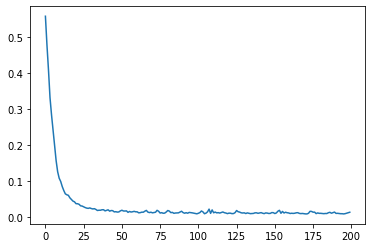

100%|██████████| 20/20 [1:44:48<00:00, 314.41s/it]

loss: tensor(0.0127)


In [53]:
import time

start = time.time()

index = 0

seed = 0

image_sizes = [256]
dist_funcs = ['logistic', 'gaussian', 'exponential', 'gamma', 'mlp']
args.dist_shape = 2
squ = [False]

nums_iterations_meta = [50]#[50, 70, 100]
learning_rates_meta = [0.1]#, 0.1, 0.03]#[0.3, 0.1, 0.03, 0.01, 1e-4]
nums_iterations_train = [200]

for size in image_sizes:
    for iter_ in nums_iterations_meta:
        for lr in learning_rates_meta:
            for sq in squ:
                for num in nums_iterations_train:
                    for func in dist_funcs:
                        
                        all_hist_loss = []
                        print(f"index {index}")
                        print(f'image size: {size}, meta iters: {iter_}, meta lr: {lr}, sq: {sq}, func: {func}')
                        print(vars(args))

                        for run in tqdm(range(20)):
                            
                            args.image_size = size
                            args.num_iterations_meta = iter_
                            args.learning_rate_meta = lr
                            args.squared = sq
                            args.dist_func = func
                            args.num_iterations_train = num
                            args.init_weight = False

                            diff_renderer,  hard_renderer = get_renderer()
                            all_images = get_goals()

                            model, diff_renderer = experiment(diff_renderer)
                            index += 1
                        np.savetxt(f'20_loss_transfer_{args.model_obj}_{args.dist_func}_{args.image_size}.txt',all_hist_loss)


end = time.time()

In [36]:
mesh, laplacian_loss, flatten_loss = model(len(cameras))
mesh = lighting(mesh)
mesh = transform(mesh)
images_pred = diff_renderer(mesh)[:,3]
image = images_pred[0].cpu().detach().numpy()
image.max()

1.0

In [37]:
gt = images_gt.cpu().detach().numpy()

In [153]:
(((gt) - (image)) ** 2).mean()

0.31501487

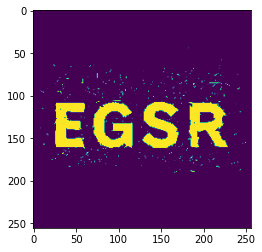

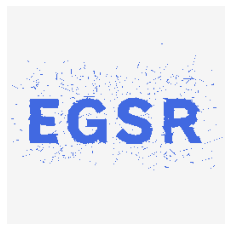

In [27]:
mesh, laplacian_loss, flatten_loss = model(len(cameras))
mesh = lighting(mesh)
mesh = transform(mesh)
images_pred = diff_renderer(mesh)[:,3]
image = images_pred[0].cpu().detach().numpy()
plt.imshow((255*image).astype(np.uint8))
plt.show()

from PIL import Image
from matplotlib import cm, colors

cmap = colors.ListedColormap(['whitesmoke', 'royalblue'])
bounds=[0, 0.1, 255]
norm = colors.BoundaryNorm(bounds, cmap.N)

viridis = cm.viridis

im = Image.fromarray(np.uint8(cmap(image*255)*255))

# thresh = 0.5
# fn = lambda x : 255 if x > thresh else 0
# r = Image.fromarray(np.uint8((image))).convert('L').point(fn, mode='1')
# plt.imshow(r)
# plt.show()

plt.axis("off")
plt.imshow(im)
plt.savefig(f"shape2D_EGSR_{dist_funcs[0]}_colored.pdf",bbox_inches='tight', pad_inches=0, dpi = 300)
Image.fromarray(np.uint8(image*255)).save(f"shape2D_EGSR_{dist_funcs[0]}.pdf")

# Error

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape2D_EGSR_ref.jpg


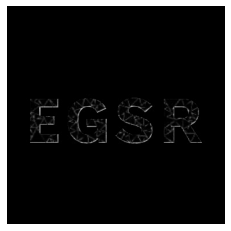

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


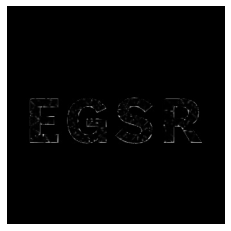

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


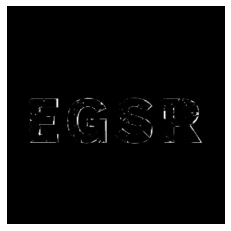

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


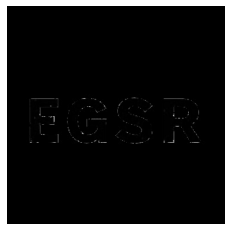

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


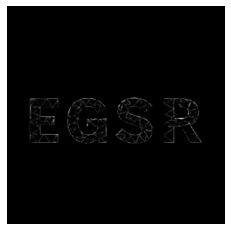

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


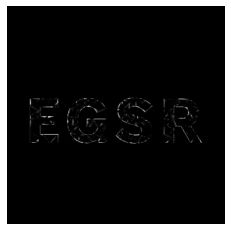

In [65]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from matplotlib import cm, colors

cmap = colors.ListedColormap(['whitesmoke', 'royalblue'])
bounds=[0, 120, 255]
norm = colors.BoundaryNorm(bounds, cmap.N)

res_path = os.path.join(os.path.abspath(""),"final results/shape2D/EGSR")

# img = Image.open(os.path.join(os.path.abspath(""),"data/EGSR/target.jpg"))
# img.load()
# data = np.asarray( img, dtype="int32" )
# plt.imshow(data)
# Image.fromarray(np.uint8(data)).save(f"shape2D_EGSR_ref.pdf")

# plot_color_gradients('Qualitative',
#                      ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
#                       'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b',
#                       'tab20c'])
ref = None
images = []
names = []
for res in os.listdir(res_path):
    if res.endswith(".jpg"):
        if res.__contains__("ref"):
            print(res)
            img = Image.open(os.path.join(res_path,res))
            img.load()
            ref = np.asarray(img, dtype="int32")
        else:
            names.append(res)
            img = Image.open(os.path.join(res_path,res))
            img.load()
            images.append(np.asarray(img, dtype="int32"))

for n,i in zip(names,images):
    name = n.split(".")[0]
    i = cv2.resize(np.uint8(i), (378, 378))

#     im = Image.fromarray(np.uint8(ref - i))
#     print(im)
    plt.axis("off")
    plt.imshow(ref-i)
    plt.savefig(f"{name}_diff.pdf",bbox_inches='tight', pad_inches=0, dpi = 300)
    plt.show() 

In [21]:
ref.shape

(378, 378, 3)

In [14]:
print(os.path.abspath(""))

/net/scratch2/b08593hm/Metaras_H/cleaned experiments


# Plot Weights

In [19]:
# file = 'data/weights/shape2D_127_256_0.03_0.068.pth'
# # file = 'data/shape_avr.pth'

In [20]:
# import torch
# import tqdm
# import numpy as np
# import torch.nn as nn
# import matplotlib.pyplot as plt

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         # an affine operation: y = Wx + b
#         self.fc1 = nn.Linear(1, 4, bias=False)  # 5*5 from image dimension
#         self.fc2 = nn.Linear(4, 4, bias=False)
#         self.fc3 = nn.Linear(4, 4, bias=False)
#         self.fc4 = nn.Linear(4, 4, bias=False)
#         self.fc5 = nn.Linear(4, 1, bias=False)

#     def forward(self, x):
#         x = torch.flatten(x, 1).unsqueeze(-1) # flatten all dimensions except the batch dimension
#         x = torch.tanh(self.fc1(x))
#         res = x
#         x = torch.tanh(self.fc2(x))
#         x = torch.tanh(self.fc3(x))
#         x = torch.tanh(res+self.fc4(x))
#         x = torch.sigmoid(self.fc5(x))
#         return x

# net = Net()

# weights0 = list(torch.load(file).values())

# i = 0
# for param in net.parameters():
#   param.data = weights0[i]
#   i += 1

# x1 = torch.linspace(-1,1,100)[...,None]

# plt.plot(x1.flatten().detach().numpy(), net(x1.to("cuda")).cpu().flatten().detach().numpy())

# plt.show()